In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_geometric.data import HeteroData
from torch_geometric.nn import SAGEConv
from itertools import product

def select_device():
    if torch.cuda.is_available():
        return 'cuda:0'
    elif torch.backends.mps.is_available():
        return 'mps:0'
    else:
        return 'cpu'

device = select_device()
device

'mps:0'

In [21]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [22]:
import os
directory = '/content/drive/MyDrive/network_ml/project'
print(os.listdir(directory))
os.chdir(directory)
print(os.listdir())


['sample.csv', 'data', 'notebook.ipynb', 'wandb']
['sample.csv', 'data', 'notebook.ipynb', 'wandb']


# 1 Data Exploration

In [2]:
books = pd.read_csv('data/books.csv', index_col=None)
tags = pd.read_csv('data/tags.csv', index_col=None)
tags = tags.merge(pd.read_csv('data/book_tags.csv'), how='inner', on='tag_id')
ratings = pd.read_csv('data/ratings.csv')
to_read = pd.read_csv('data/to_read.csv')

## Books

### 1) Books per Year

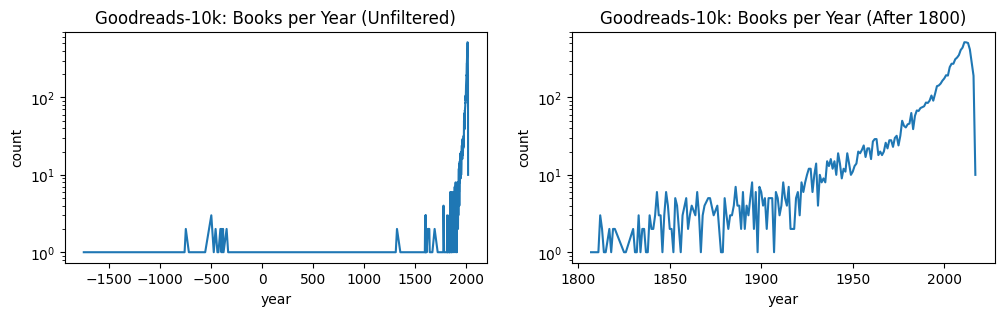

In [3]:
import seaborn as sns

books_per_year = books[(books.original_publication_year.notna()) & (books.language_code.notna())]\
        .groupby(['original_publication_year'])\
        .agg(count=pd.NamedAgg('book_id', 'size'))\
        .reset_index(names=['year'])

fig, ax = plt.subplots(1, 2, sharex=False, figsize=(12,3))

l = sns.lineplot(books_per_year, x='year', y='count', ax=ax[0])
l.set_title("Goodreads-10k: Books per Year (Unfiltered)")
l.set_yscale("log")

r = sns.lineplot(books_per_year.copy()[books_per_year.year > 1800], x='year', y='count', ax=ax[1])
r.set_title("Goodreads-10k: Books per Year (After 1800)")
r.set_yscale("log")


**Observation:** there exists a few books that are very old. We anticipate these books being less relevant for most users, and have therefore opted to filter them out, thus prioritizing newer book releases. This removes roughly 150 books from our dataset.

### 2) Books per Language

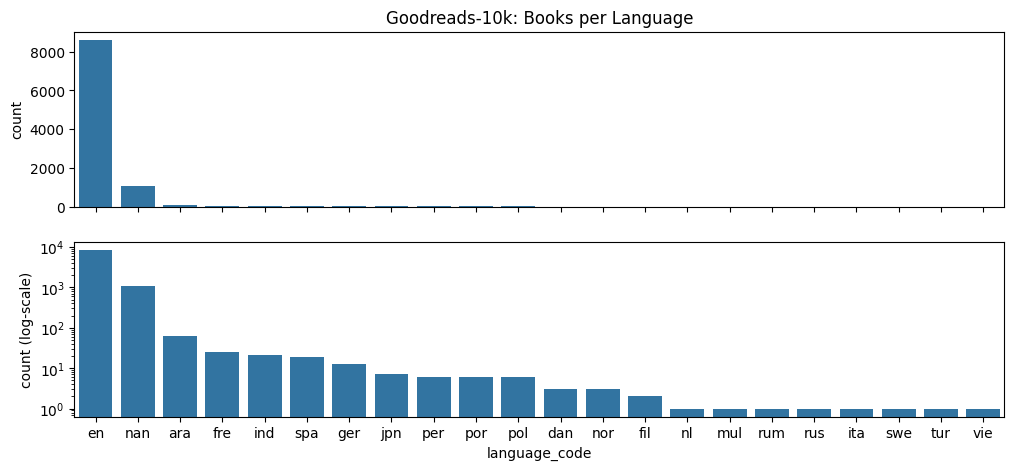

In [4]:
# Standardize english
english_variants = [x for x in books.language_code.unique() if pd.notnull(x) and x.find('en') != -1]
books['language_code'] = books.language_code.apply(lambda x: x if x not in english_variants else 'en')

books = books[books.original_publication_year > 1800]
books_per_language = books.groupby('language_code', dropna=False)\
                          .agg(count=pd.NamedAgg('book_id', 'size'))\
                          .reset_index()\
                          .sort_values('count', ascending=False)

books_per_language['language_code'] = books_per_language.language_code.apply(lambda x: 'nan' if pd.isna(x) else x)

fig, ax = plt.subplots(2, 1, sharex=True, figsize=(12,5))
g = sns.barplot(books_per_language.sort_values('count', ascending=False), x='language_code', y='count', ax=ax[0])
g.set_ylabel('count')
g.set_title('Goodreads-10k: Books per Language')

g = sns.barplot(books_per_language.sort_values('count', ascending=False), x='language_code', y='count', ax=ax[1])
g.set_yscale('log')
g.set_ylabel('count (log-scale)')
plt.show()

**Observation:** The vast majority of books are written in english. Hence, we decide to focus solely on these.

### Books per Author

remaining number of books: 8612
number of authors: 5026


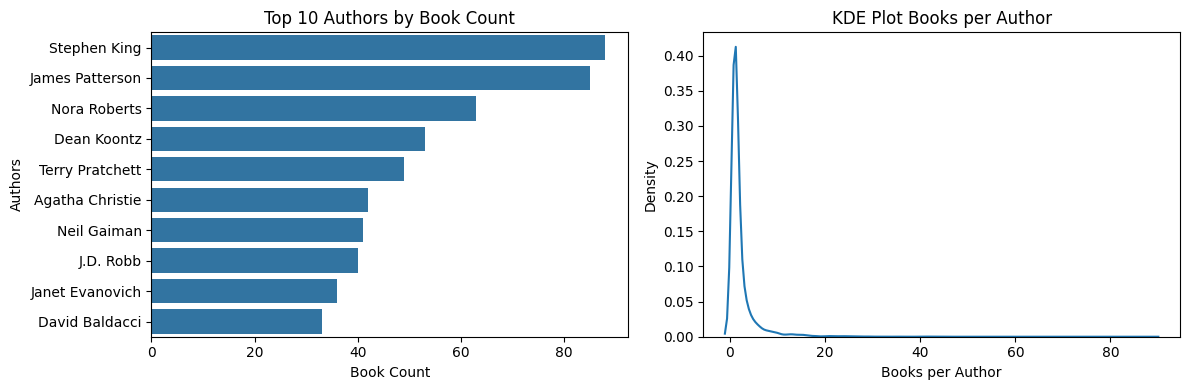

In [5]:
books = books[books.language_code == 'en']

books_authors = books.copy()
books_authors['authors'] = books_authors.authors.apply(lambda x: [x.strip() for x in x.split(',')])
books_authors = books_authors.explode('authors')

books_authors = books_authors.groupby('authors')\
                             .agg(count=pd.NamedAgg('book_id', 'size'))\
                             .reset_index()\
                             .sort_values('count', ascending=False)

print('remaining number of books:', books.shape[0])
print('number of authors:', books_authors.shape[0])

# Create the subplots
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Left subplot: Bar chart of top 10 authors
sns.barplot(data=books_authors.head(10), x='count', y='authors', ax=ax[0])
ax[0].set_title('Top 10 Authors by Book Count')
ax[0].set_xlabel('Book Count')
ax[0].set_ylabel('Authors')

# Right subplot: CCDF plot
sns.kdeplot(books_authors, x='count', ax=ax[1])
ax[1].set_title('KDE Plot Books per Author')
ax[1].set_xlabel('Books per Author')
ax[1].set_ylabel('Density')

plt.tight_layout()
plt.show()

### 4) Rating Distributions

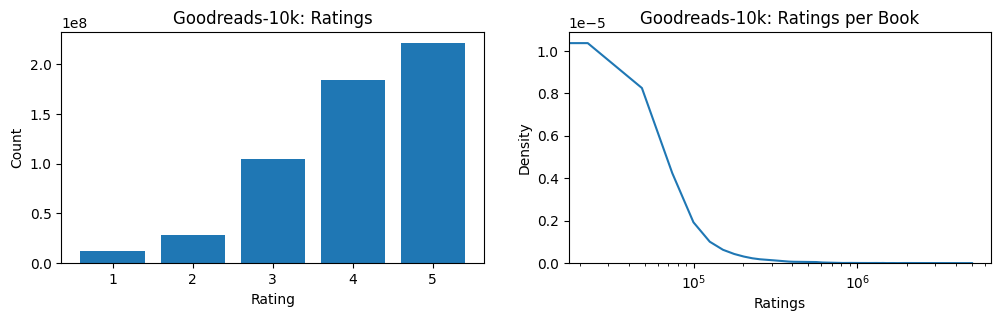

count    8.612000e+03
mean     6.398287e+04
std      1.777237e+05
min      6.823000e+03
25%      1.610875e+04
50%      2.508300e+04
75%      4.941275e+04
max      4.942365e+06
Name: work_ratings_count, dtype: float64

In [6]:
cols = [f'ratings_{i+1}' for i in range(5)]
rating_counts = [books[x].sum() for x in cols]

fig, ax = plt.subplots(1, 2, sharex=False, figsize=(12,3))

ax[0].bar([x[-1] for x in cols], rating_counts)
ax[0].set_title("Goodreads-10k: Ratings")
ax[0].set_xlabel('Rating')
ax[0].set_ylabel('Count')

g = sns.kdeplot(books, x='work_ratings_count', ax=ax[1])
g.set_xscale('log')
g.set_title('Goodreads-10k: Ratings per Book')
g.set_xlabel('Ratings')

plt.show()

books['work_ratings_count'].describe()

**Observations:** in the left subplot, we clearly see that higher ratings are more prevalent than lower ratings. Surprisingly, the most common rating is 5 stars, with more than 2 million counts. There is a noticeable skew towards higher ratings (4 and 5 stars), indicating that users tend to rate books more favorably. The right subplot shows the density distribution of the number of ratings each book receives, plotted on a log-scale for the x-axisThe majority of books have a lower number of ratings, with the density rapidly decreasing as the number of ratings increases. This indicates that most books receive fewer than 10,000 ratings, which can also be seen from the descriptive statistics printed under the plot. The fact that some books recieve way more attention than others is expected, and a typical characteristic of real-world networks.

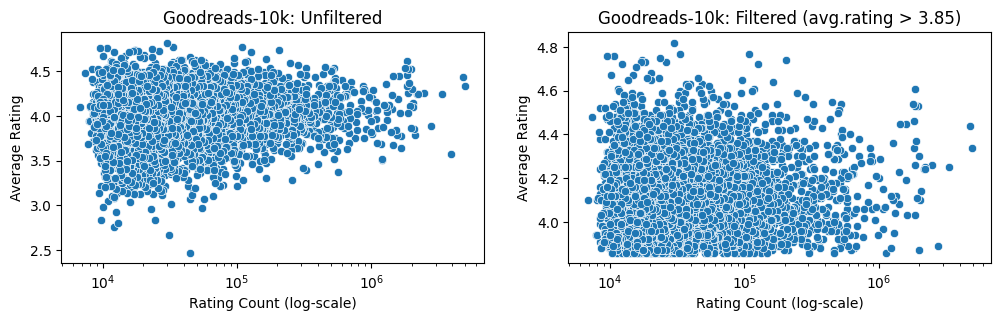

count    8612.000000
mean        4.004494
std         0.252290
min         2.470000
25%         3.850000
50%         4.020000
75%         4.180000
max         4.820000
Name: average_rating, dtype: float64

In [7]:
fig, ax = plt.subplots(1,2, figsize=(12,3))

g = sns.scatterplot(books, x='work_ratings_count', y='average_rating', ax=ax[0])
g.set_xscale('log')
g.set_title('Goodreads-10k: Unfiltered')
g.set_xlabel('Rating Count (log-scale)')
g.set_ylabel('Average Rating')

g = sns.scatterplot(books[books.average_rating > 3.85], x='work_ratings_count', y='average_rating', ax=ax[1])
g.set_title('Goodreads-10k: Filtered (avg.rating > 3.85)')
g.set_xscale('log')
g.set_xlabel('Rating Count (log-scale)')
g.set_ylabel('Average Rating')

plt.show()

books['average_rating'].describe()

## To Read

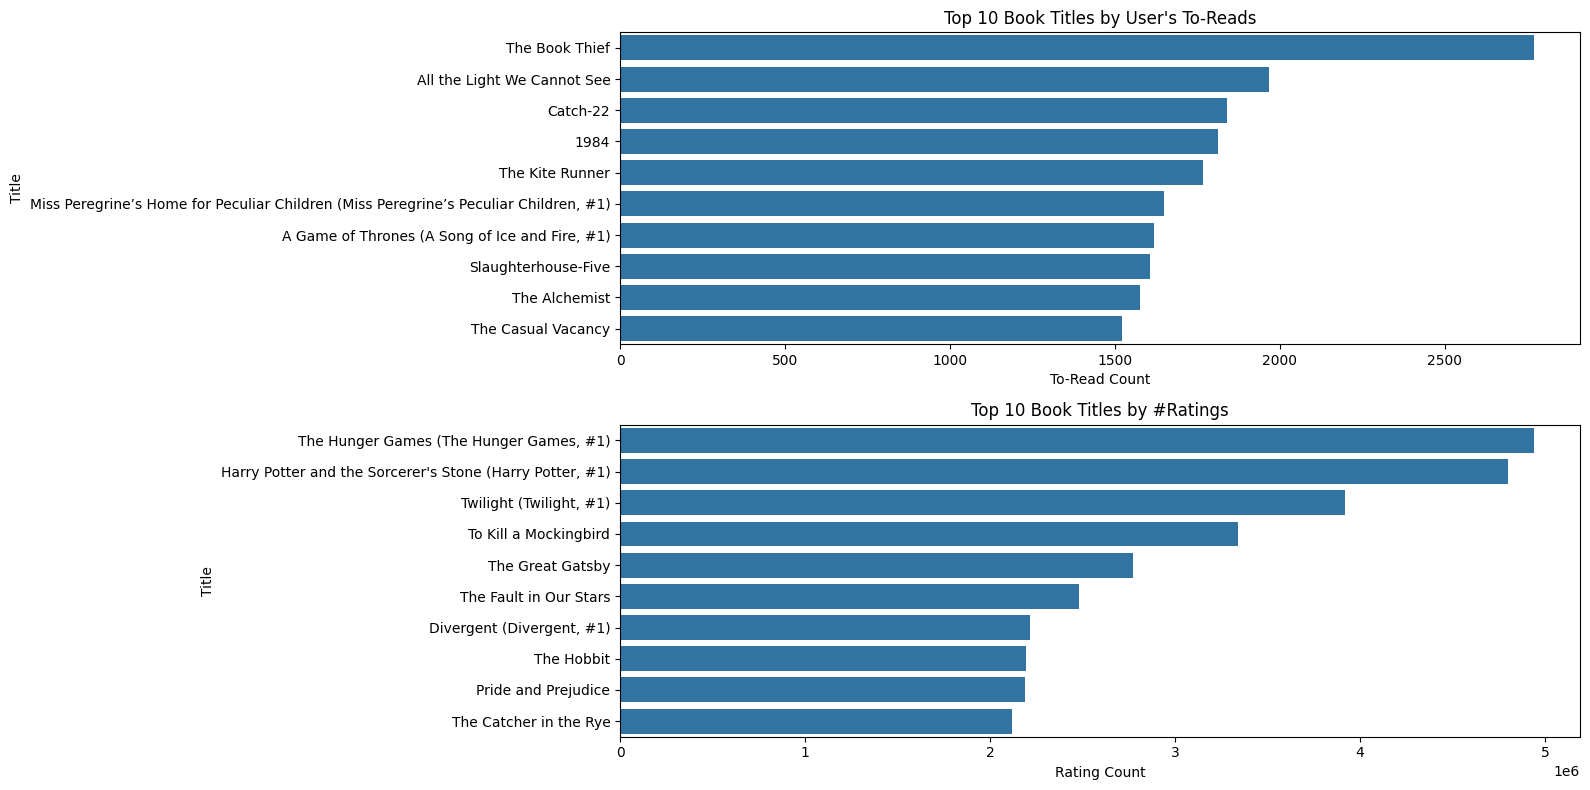

In [8]:
grouped_to_read = to_read.groupby('book_id')\
                        .agg(count=pd.NamedAgg('book_id', 'size'))\
                        .reset_index()\
                        .sort_values('count', ascending=False)

grouped_to_read = books[['book_id', 'title']].merge(grouped_to_read, how='inner', on='book_id')


fig, ax = plt.subplots(2, 1, figsize=(16, 8))

# Left subplot: Bar chart of top 10 authors
g = sns.barplot(data=grouped_to_read.sort_values('count', ascending=False).head(10), x='count', y='title', ax=ax[0])
g.set_title("Top 10 Book Titles by User's To-Reads")
g.set_xlabel('To-Read Count')
g.set_ylabel('Title')

g = sns.barplot(data=books.sort_values('work_ratings_count', ascending=False).head(10), x='work_ratings_count', y='title', ax=ax[1])
g.set_title("Top 10 Book Titles by #Ratings")
g.set_xlabel('Rating Count')
g.set_ylabel('Title')

plt.tight_layout()
plt.show()

**Observation:** from the above plot, we do not see any overlap between the top 10 books on number of to-reads and number of ratings. We hypothesize that this might be due to the fact that users by definition only will have books on their "to read"-list before reading them. Books rated by most users have likely already been read by most users, meaning they won't necessarily appear on a lot of to-read lists despite the books being popular.

In [9]:
from scipy.stats import pearsonr

books2read = books[['book_id', 'work_ratings_count', 'average_rating']].merge(grouped_to_read, how='inner', on='book_id')

popularity_to_read_corr, popularity_to_read_pvalue = pearsonr(books2read['work_ratings_count'], books2read['count'])
rating_to_read_corr, rating_to_read_pvalue = pearsonr(books2read['average_rating'], books2read['count'])

print(f"Correlation between book popularity (rating count) and to_read count: {popularity_to_read_corr} (p-value: {popularity_to_read_pvalue})")
print(f"Correlation between average rating and to_read count: {rating_to_read_corr} (p-value: {rating_to_read_pvalue})")


Correlation between book popularity (rating count) and to_read count: 0.639906458167583 (p-value: 0.0)
Correlation between average rating and to_read count: 0.0006685639456719913 (p-value: 0.9505527249304179)


**Observation:** there is a statistically significant (p-value of 0.0) correlation between a book's popularity and the number of users having it on their "to read"-list. Not surprisingly, there is not a similar correlation between average rating and "to read"-count.

## Ratings

### 1) Ratings per Book

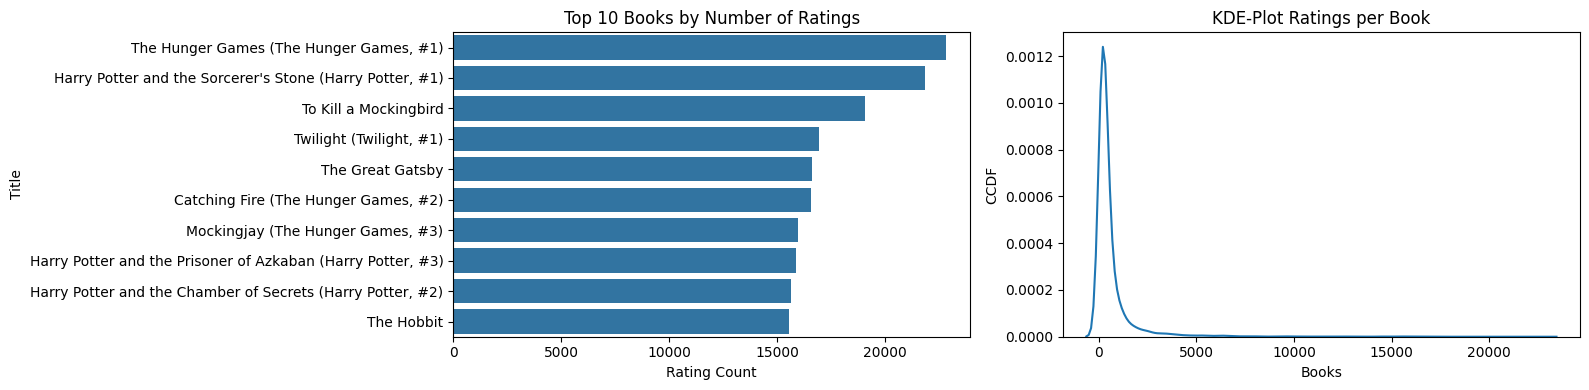

Total number of ratings: 5461106


count     8612.000000
mean       634.127497
std       1327.572209
min          8.000000
25%        162.000000
50%        261.000000
75%        544.250000
max      22806.000000
Name: count, dtype: float64

In [10]:
ratings_per_book = ratings.groupby('book_id')\
                          .agg(count=pd.NamedAgg('rating', 'size'))\
                          .reset_index()\
                          .sort_values('count', ascending=False)

ratings_per_book = ratings_per_book.merge(books[['book_id', 'title']], how='inner', on='book_id')

# Create the subplots
fig, ax = plt.subplots(1, 2, figsize=(16, 4))

# Left subplot: Bar chart of top 10 authors
sns.barplot(data=ratings_per_book.head(10), x='count', y='title', ax=ax[0])
ax[0].set_title('Top 10 Books by Number of Ratings')
ax[0].set_xlabel('Rating Count')
ax[0].set_ylabel('Title')

# Right subplot: CCDF plot
sns.kdeplot(ratings_per_book, x='count')
ax[1].set_title('KDE-Plot Ratings per Book')
ax[1].set_xlabel('Books')
ax[1].set_ylabel('CCDF')

plt.tight_layout()
plt.show()

print('Total number of ratings:', ratings_per_book['count'].sum())
ratings_per_book['count'].describe()

**Observation:** there are roughly 5,5 million ratings present in the dataset. In the above plot, we see the Harry Potter and Hunger Games books being well represented in terms of the most number of ratings per book. We also observe that the least number of ratings per book is 8. Mean number of ratings is 634, while the median is 261. However, there is a significant skewness as the most ratings per book is 22,8k. To ensure that we have enough data points for our predictions, we have decided to filter out books with less than 200 ratings.

### 2) Ratings per User

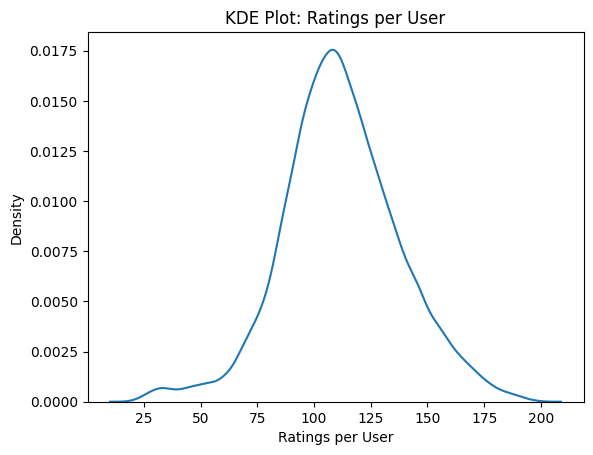

count    53424.000000
mean       111.868804
std         26.071224
min         19.000000
25%         96.000000
50%        111.000000
75%        128.000000
max        200.000000
Name: count, dtype: float64

In [11]:
ratings_per_user = ratings.groupby('user_id')\
                          .agg(count=pd.NamedAgg('rating', 'size'))\
                          .reset_index()\
                          .sort_values('count', ascending=False)

g = sns.kdeplot(ratings_per_user, x='count')
g.set_title('KDE Plot: Ratings per User')
g.set_xlabel('Ratings per User')
plt.show()

ratings_per_user['count'].describe()

**Observation:** to ensure that we have enough data per user to make informed decisions/recommendations, we filter out users with less than 100 ratings. This leaves us with a significant proportion of users, while removing the ones we know less about.

In [12]:
book_ids_200 = ratings_per_book[ratings_per_book['count'] > 200]['book_id'].tolist()
user_ids_100 = ratings_per_user[ratings_per_user['count'] > 100]['user_id'].tolist()
final_ratings = ratings[(ratings.user_id.isin(user_ids_100)) & (ratings.book_id.isin(book_ids_200))]

print('Final number of ratings:', final_ratings.shape[0])
print('Final number of users:', final_ratings.user_id.nunique())
print('Final number of books:', final_ratings.book_id.nunique())

Final number of ratings: 3853654
Final number of users: 36199
Final number of books: 5422


In [13]:
user_ids = final_ratings.groupby('user_id')\
                        .agg(count=pd.NamedAgg('rating', 'size'))\
                        .reset_index()\
                        .sample(3000, weights='count', random_state=42)\
                        .user_id.tolist()

book_ids = final_ratings.groupby('book_id')\
                        .agg(count=pd.NamedAgg('rating', 'size'))\
                        .reset_index()\
                        .sample(1500, weights='count', random_state=42)\
                        .book_id.tolist()

sampled_ratings = final_ratings[(final_ratings.user_id.isin(user_ids)) & (final_ratings.book_id.isin(book_ids))]

print('Sampled number of ratings:', sampled_ratings.shape[0])
print('Sampled number of users:', sampled_ratings.user_id.nunique())
print('Sampled number of books:', sampled_ratings.book_id.nunique())

Sampled number of ratings: 197804
Sampled number of users: 3000
Sampled number of books: 1500


# Rating Prediction

### Stratified User Split

In [68]:
from typing import Tuple

def stratified_user_split(df: pd.DataFrame, train_size: float = 0.70) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Stratified split of the DataFrame ensuring each user is in both train and test sets.
    """
    train_list = []
    test_list = []

    for _, group in df.groupby('user_id'):
        train_count = int(len(group) * train_size)
        train = group.sample(n=train_count, random_state=42)
        test = group.drop(train.index)

        train_list.append(train)
        test_list.append(test)

    train_df = pd.concat(train_list).reset_index(drop=True)
    test_df = pd.concat(test_list).reset_index(drop=True)

    return train_df, test_df

In [69]:
# Stratified train-test split to maintain the same users in both sets
train_size = 0.70
train, test = stratified_user_split(sampled_ratings, train_size)

# Displaying the shape of train and test sets and checking user overlap
print(f'Train Shape: {train.shape}')
print(f'Test Shape: {test.shape}')
print(f'Same Users: {set(train.user_id) == set(test.user_id)}')

Train Shape: (137067, 3)
Test Shape: (60737, 3)
Same Users: True


### Evaluation Framework

In [38]:
def evaluate_recommendations(recommendations, truth, k):
    # Filter top k recommendations for each user
    top_k_recs = recommendations.groupby('user_id').head(k)

    # Merging with truth data to find relevant recommendations
    merged = pd.merge(top_k_recs, truth, on=['user_id', 'book_id'], how='inner')

    # Calculate precision and recall at k for each user
    user_precision = merged.groupby('user_id').size() / top_k_recs.groupby('user_id').size()
    user_recall = merged.groupby('user_id').size() / truth.groupby('user_id').size()

    ndcg = ndcg_at_k(recommendations, truth, k)
    mrr = mean_reciprocal_rank(recommendations, truth, k)

    # Average over all users
    return {
        f"precision@{k}": user_precision.mean(),
        f"recall@{k}": user_recall.mean(),
        f"ndcg@{k}": ndcg,
        f"mrr@{k}": mrr
    }

def mean_reciprocal_rank(recommendations, truth, k):
    top_k_recs = recommendations.groupby('user_id').head(k)
    merged = pd.merge(top_k_recs, truth, on=['user_id', 'book_id'], how='left')
    # Assign ranks to each recommendation for each user
    merged['rank'] = merged.groupby('user_id').cumcount() + 1
    # Focus on rows where there is a match (rating is not NaN)
    relevant_ranks = merged[merged['rating'].notna()]
    # Compute the reciprocal of the first relevant item's rank per user
    reciprocal_ranks = relevant_ranks.groupby('user_id')['rank'].min().apply(lambda x: 1.0 / x)
    # Average over all users
    return reciprocal_ranks.mean()

def ndcg_at_k(recommendations, truth, k):
    top_k_recs = recommendations.groupby('user_id').head(k)
    merged = pd.merge(top_k_recs, truth, on=['user_id', 'book_id'], how='left').fillna(0)

    # Calculate DCG
    merged['rank'] = merged.groupby('user_id').cumcount() + 1
    merged['dcg'] = (2**merged['rating'] - 1) / np.log2(merged['rank'] + 1)
    dcg = merged.groupby('user_id')['dcg'].sum()

    # Calculate IDCG using the top-k sorted true items per user
    truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)
    truth_sorted['rank'] = truth_sorted.groupby('user_id').cumcount() + 1
    truth_sorted['idcg'] = (2**truth_sorted['rating'] - 1) / np.log2(truth_sorted['rank'] + 1)
    idcg = truth_sorted.groupby('user_id')['idcg'].sum()

    # Calculate NDCG by dividing DCG by IDCG
    return (dcg / idcg).fillna(0).mean()


## Singular Value Decomposition (SVD)

Singular Value Decomposition (SVD) is a matrix factorization technique that decomposes a matrix $A$ into three matrices - $U, \Sigma, V^T $, where $U$ is an $m \times r$ orthogonal matrix representing the user features vectors, $\Sigma$ is an $r \times r$ diagonal matrix containing singular values, and $V^T$ is the transpose of an $n \times n$ orthogonal matrix representing the item feature vectors. $r$ represents the rank of matrix $A$.

In [88]:
from surprise import Dataset, Reader, SVD
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate

### Train & Test

In [89]:
# Setting up the reader with rating scale based on the train set
reader = Reader(rating_scale=(train['rating'].min(), train['rating'].max()))
data = Dataset.load_from_df(train[['user_id', 'book_id', 'rating']], reader)  # Assuming 'book_name' should be 'book_id'

# SVD model instantiation with specified hyperparameters
svd = SVD(random_state=42, n_epochs=25, lr_all=5e-4, n_factors=50, reg_all=0.05, verbose=False)

# Performing 5-fold cross-validation to evaluate the model
cross_validation_results = cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=6, verbose=True)

# Calculating and printing the mean RMSE and MAE
mean_rmse = cross_validation_results['test_rmse'].mean()
mean_mae = cross_validation_results['test_mae'].mean()
print(f"Mean RMSE: {mean_rmse}")
print(f"Mean MAE: {mean_mae}")

# Fitting the SVD model on the entire train set
surprise_train = data.build_full_trainset()
svd.fit(surprise_train)

Evaluating RMSE, MAE of algorithm SVD on 6 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Mean    Std     
RMSE (testset)    0.9160  0.9096  0.9073  0.9168  0.9098  0.9192  0.9131  0.0044  
MAE (testset)     0.7303  0.7245  0.7225  0.7288  0.7268  0.7296  0.7271  0.0028  
Fit time          0.47    0.48    0.48    0.51    0.54    0.49    0.50    0.02    
Test time         0.07    0.07    0.07    0.08    0.07    0.07    0.07    0.00    
Mean RMSE: 0.9131135779175352
Mean MAE: 0.7271077430862211


### Recommendations

In [90]:
print('Create anti-set and make predictions...')
testset = surprise_train.build_anti_testset()
predictions = svd.test(testset)

print('Filter predictions on unseen interactions...')
predictions_df = pd.DataFrame(predictions, columns=['user_id', 'book_id', 'avg_rating_user', 'pred_rating', 'details'])
known_interactions = train[['user_id', 'book_id']].copy()
known_interactions['in_trainset'] = True
predictions_df = predictions_df.merge(known_interactions, on=['user_id', 'book_id'], how="left")
predictions_df = predictions_df[predictions_df['in_trainset'].isna()][['user_id', 'book_id', 'pred_rating']]

Create anti-set and make predictions...
Filter predictions on unseen interactions...


In [91]:
top_k = 20
print(f'Get {top_k} recommendations for each user...')
sorted_predictions = predictions_df.sort_values(['user_id', 'pred_rating'], ascending=[True, False])
grouped = sorted_predictions.groupby('user_id').head(top_k)
svd_recommendations = grouped.reset_index(drop=True)

Get 20 recommendations for each user...


### Evaluation

In [92]:
svd_performance = {'model': 'svd'}
svd_performance.update(evaluate_recommendations(svd_recommendations.sort_values(by=['user_id', 'pred_rating'], ascending=[True, False]), test, 20))
svd_performance

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'svd',
 'precision@20': 0.10777833001988073,
 'recall@20': 0.10189346395151298,
 'ndcg@20': 0.079221761985111,
 'mrr@20': 0.2863232735401426}

##   User-Based Collaborative Filtering (UCBF)

The general idea behind user-based collaborative filtering is that people often get good recommendations from those with similar taste. In UCBF, we derive a user-to-user similarity matrix by computing the cosine similarity of each user's ratings in the user-item interaction matrix. From the resulting similarity matrix, one can select the $n$ most similar users and base recommendations on their preferences, by computing a weighted average of the these users' ratings using their cosine similarity as weights. By normalizing the resulting score by the sum of the weights, we obtain scores in the range 1-5 which can be interpreted as ratings. For recommendations, we select the top $k$ candidates among these scores.

In [95]:
from sklearn.metrics.pairwise import cosine_similarity

interaction_matrix = train.pivot(index='user_id', columns='book_id', values='rating').fillna(0)
# Compute the cosine similarity between users
user_similarities = cosine_similarity(interaction_matrix)
user_similarities_df = pd.DataFrame(user_similarities, index=interaction_matrix.index, columns=interaction_matrix.index)

In [133]:
def recommend_ubcf(interaction_matrix, user_similarities, user_id, k=10, n_neighbors=5, non_zero=False):
    '''
    Steps:
    1. Find the top N most similar users
    2. Get the ratings of the similar users
    3. Compute the weighted average of the ratings of similar users
    4. Normalize by the sum of similarities
    5. Filter out books that the user has already rated
    '''
    neighbours = user_similarities[user_id].sort_values(ascending=False)[1:n_neighbors+1]
    similar_users, similarity_weights = neighbours.index, neighbours.to_numpy()

    # Get the ratings of the similar users
    similar_users_ratings = interaction_matrix.loc[similar_users]

    # Compute the weighted ratings only for non-zero ratings
    weighted_ratings = pd.Series(0, index=interaction_matrix.columns, dtype=float)
    sum_of_weights = pd.Series(0, index=interaction_matrix.columns, dtype=float)

    for i, user in enumerate(similar_users):
        ratings = similar_users_ratings.loc[user]

        weights = similarity_weights[i] * (ratings != 0) if non_zero else similarity_weights[i]
        weighted_ratings += ratings * weights
        sum_of_weights += weights

    # Avoid division by zero
    non_zero_weights = sum_of_weights != 0
    weighted_ratings[non_zero_weights] /= sum_of_weights[non_zero_weights]

    # Filter out books that the user has already rated
    user_rated_books = interaction_matrix.loc[user_id].replace(0, np.nan).dropna().index
    recommendations = weighted_ratings.drop(user_rated_books).sort_values(ascending=False).head(k).to_dict()

    return [{'user_id': user_id, 'book_id': b, 'pred_rating': round(s, 6)} for b, s in recommendations.items() if s > 0.0]

def get_ucbf_recommendations(interaction_matrix, user_similarities, k=10, n_neighbors=5, non_zero=False):
    all_recommendations = []
    user_ids = interaction_matrix.index

    for user_id in tqdm(user_ids, desc='User'):
        recommendations = recommend_ubcf(interaction_matrix, user_similarities, user_id, k=k, n_neighbors=n_neighbors, non_zero=non_zero)
        all_recommendations.extend(recommendations)
    

    return pd.DataFrame(all_recommendations)#.sort_values(by=['user_id', 'pred_rating'], ascending=[True, False])

In [97]:
ucbf_recommendations_standard = get_ucbf_recommendations(interaction_matrix, user_similarities_df, 20, 5, False)
ucbf_recommendations_non_zero = get_ucbf_recommendations(interaction_matrix, user_similarities_df, 20, 5, True)

User: 100%|██████████| 3000/3000 [00:11<00:00, 272.66it/s]


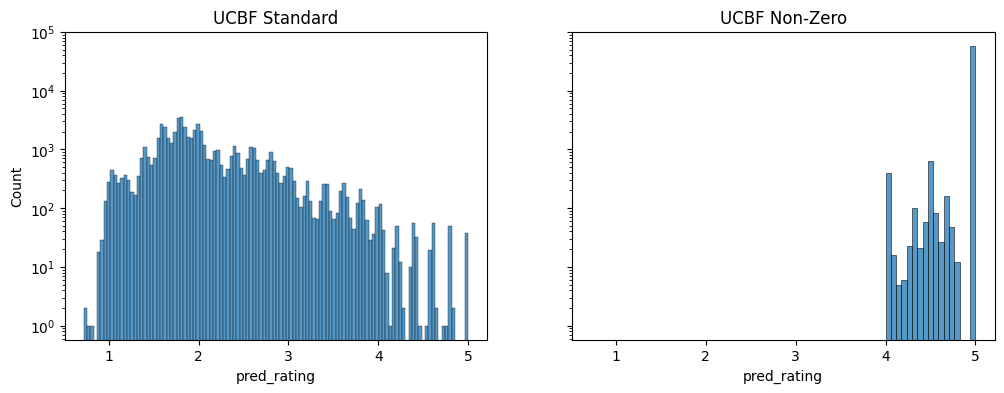

In [98]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)
g = sns.histplot(ucbf_recommendations_standard,x='pred_rating', ax=ax[0])
g.set_yscale('log')
g.set_title('UCBF Standard')
g.set_xlabel('pred_rating')

g = sns.histplot(ucbf_recommendations_non_zero,x='pred_rating', ax=ax[1])
g.set_yscale('log')
g.set_title('UCBF Non-Zero')

plt.show()

**Observation:** due to the sparsity of the interaction matrix, computing the weighted average across all similar users for an item produces much greater variance in standard UCBF. If only a few of a user's most similar neighbours have interacted with a book, the weighted average is bound to be lower due to the influence of 0s. Thus, the method is actually producing a "preference similarity score" rather than an actual rating prediction. However, if our target is to predict scores interpretable as ratings, we could do a weighted average solely on the ratings present in the interaction matrix. This yields a lower RMSE and MAE, but actually bias our predictions a lot (mostly 4-5s), which can make it harder to rank predictions.

In [99]:
ucbf_standard_performance = {'model': 'ucbf_standard'}
ucbf_standard_performance.update(evaluate_recommendations(ucbf_recommendations_standard, test, 20))
ucbf_standard_performance

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'ucbf_standard',
 'precision@20': 0.20706860706860702,
 'recall@20': 0.20826609844201346,
 'ndcg@20': 0.23379131637618347,
 'mrr@20': 0.5902373835646639}

In [100]:
ucbf_nz_performance = {'model': 'ucbf_nz'}
ucbf_nz_performance.update(evaluate_recommendations(ucbf_recommendations_non_zero, test, 20))
ucbf_nz_performance

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'ucbf_nz',
 'precision@20': 0.10164113785557988,
 'recall@20': 0.10335560001538453,
 'ndcg@20': 0.08110997614269451,
 'mrr@20': 0.32846052469471454}

We obsere that the standard UCBF is superior to the non-zero variant, suggesting it is not beneficial to force rating-prediction by only relying on information present in the interaction matrix. This could be attributed to the fact that missing interactions could potentially be an active decision - users might actively decide not to interact with certain content.

## Hybrid: SVD + UBCF

Let's try implement UCBF with the latent user representation obtained in SVD. to do so, we compute the new user-similarity matrix and then rerun our experiments.

In [137]:
user_factors = svd.pu
user_similarities_svd = cosine_similarity(user_factors)
user_similarities_svd_df = pd.DataFrame(user_similarities, index=interaction_matrix.index, columns=interaction_matrix.index)

hucbf_svd_u_recommendations = get_ucbf_recommendations(interaction_matrix, user_similarities_svd_df, 20, 5, False)

User: 100%|██████████| 3000/3000 [00:06<00:00, 435.73it/s]


In [138]:
hucbf_performance = {'model': 'h-ucbf+svd'}
hucbf_performance.update(evaluate_recommendations(hucbf_svd_u_recommendations, test, 20))
hucbf_performance

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'h-ucbf+svd',
 'precision@20': 0.20706860706860702,
 'recall@20': 0.20826609844201346,
 'ndcg@20': 0.23379131637618347,
 'mrr@20': 0.5902373835646639}

**Comment:** There appears to be no changes in UCBF performance when using the user_factors of SVD to compute the user similarities. This suggests that the latent representation of SVD retained UCBF performance while reducing the dimensionality from 1500 features to only 50!

## Dual-GNN

To address the bipartite nature of the graph, we also implement a custom dual GNN-architecture for rating prediction. It employs two separate GNNs that learn node embeddings for users and books respectively. Each GNN module, in our case either a GCN or GIN, computes node embeddings by aggregating and transforming local neighborhood information based on the input features $x$ and the connectivity structure provided in the $edge\_index$. In essence, node embeddings are generated by passing the input sequentially through layers of the chosen GNN architecture, where each layer updates the node's feature by incorporating features from its immediate neighbors as defined by the $edge\_index$, followed by non-linear transformations and optional dropout for regularization.

By concatenating a user and a book embedding, we then create edge embeddings which are passed to an MLP to predict the final rating. The model can be trained through a regression objective using MSE or Huber loss, or for multi-class classification using CrossEntropy. During inference, the architecture can make rating predictions on edges not seen in the train-graph through either cosine similarity or the MLP. If trained for classification, we apply softmax on the raw output logits of the MLP to compute class probabilities used in a weighted sum for rating estimation. Unlike the regression objective, this score is bounded on the [1,5] domain by definition. Additionally, one strength of this approach lies in its ability to incorporate node-features, meaning qualitz handcrafted features for users and books can improve its performance. In our experiments, we only employ features easily derived from the ratings-dataset: distribution of ratings (count per star) and mean rating. These input embeddings are then passed through GNN-layers to compute final node embeddings.

In [18]:
def create_node_embeddings(df, col):
    # Group by user_id and aggregate ratings
    node_group = df.groupby(col)['rating']

    # Calculate average rating per user
    node_df = node_group.mean().reset_index()
    node_df.rename(columns={'rating': 'avg_rating'}, inplace=True)

    # Count the occurrences of each rating value per user
    rating_counts = df.groupby(col)['rating'].value_counts().unstack(fill_value=0).reset_index()
    rating_counts.columns = [col, 'rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']

    # Merge the average rating and rating counts into one DataFrame
    node_df = node_df.merge(rating_counts, on=col, how='left')
    node_df['ratings'] = node_df[['rating_1', 'rating_2', 'rating_3', 'rating_4', 'rating_5']].sum(axis=1)

    # View the final DataFrame for users
    return node_df

train_book_features = create_node_embeddings(train, 'book_id')
train_user_features = create_node_embeddings(train, 'user_id')

train_book_features.shape, train_user_features.shape

((1500, 8), (3000, 8))

In [25]:
from sklearn.preprocessing import StandardScaler

def prepare_gnn_train_data(user_df, book_df, rating_df):
    user_df = user_df.sort_values('user_id', ascending=True)
    book_df = book_df.sort_values('book_id', ascending=True)
    rating_df = rating_df.sort_values(['user_id', 'book_id'], ascending=[True, True])

    features = ['avg_rating', 'rating_1', 'rating_2', 'rating_3', 'rating_4','rating_5', 'ratings']

    # Creating mappings
    user_id_to_idx = {id: idx for idx, id in enumerate(user_df['user_id'].unique())}
    book_id_to_idx = {id: idx for idx, id in enumerate(book_df['book_id'].unique())}

    scaler_user = StandardScaler()
    user_features = scaler_user.fit_transform(user_df[features])
    user_features = torch.tensor(user_features, dtype=torch.float)

    scaler_books = StandardScaler()
    book_features = scaler_books.fit_transform(book_df[features])
    book_features = torch.tensor(book_features, dtype=torch.float, device=select_device())

    data = HeteroData()
    data['book'].x = book_features
    data['user'].x = user_features

    # Prepare edge data with remapped indices
    edges = torch.tensor([(user_id_to_idx[row['user_id']], book_id_to_idx[row['book_id']]) for idx, row in rating_df.iterrows()], dtype=torch.long).t()
    data['user', 'book'].edge_index = edges.to(device)
    data['user', 'book'].edge_attr = torch.tensor(rating_df['rating'].values, dtype=torch.float).to(device)

    return data, user_id_to_idx, book_id_to_idx

def prepare_gnn_test_data(train_data, test_rating_df, user_id_to_idx, book_id_to_idx):
    device = select_device()  # Ensuring device consistency

    # We reuse the user and book node features from the training data
    test_data = HeteroData()
    test_data['book'].x = train_data['book'].x
    test_data['user'].x = train_data['user'].x

    # Prepare edge data with remapped indices for test set, checking for existence
    edges = torch.tensor([(user_id_to_idx.get(row['user_id']), book_id_to_idx.get(row['book_id']))
                          for idx, row in test_rating_df.iterrows()
                          if row['user_id'] in user_id_to_idx and row['book_id'] in book_id_to_idx
                          ]).t()

    test_data['user', 'book'].edge_index = edges.to(device)
    test_data['user', 'book'].edge_attr = torch.tensor(test_rating_df['rating'].values, dtype=torch.float).to(device)

    return test_data

gnn_train_data, user_id_to_idx, book_id_to_idx = prepare_gnn_train_data(train_user_features, train_book_features, train)
gnn_test_data = prepare_gnn_test_data(gnn_train_data, test, user_id_to_idx, book_id_to_idx)

gnn_train_data, gnn_test_data


(HeteroData(
   book={ x=[1500, 7] },
   user={ x=[3000, 7] },
   (user, to, book)={
     edge_index=[2, 137067],
     edge_attr=[137067],
   }
 ),
 HeteroData(
   book={ x=[1500, 7] },
   user={ x=[3000, 7] },
   (user, to, book)={
     edge_index=[2, 60737],
     edge_attr=[60737],
   }
 ))

In [192]:
from torch_geometric.nn.models import GCN, GAT, GIN, GraphSAGE, MLP
import torch
import torch.nn.functional as F
from torch_geometric.data import HeteroData

class RatingPredictorGNN(torch.nn.Module):
    def __init__(self,
                 num_user_features,
                 num_item_features,
                 gnn_layers,
                 gnn_dropout,
                 gnn_hidden_channels,
                 mlp_layers,
                 mlp_hidden_channels,
                 mlp_dropout,
                 problem_formulation='regression',
                 architecture='GCN'):
        super(RatingPredictorGNN, self).__init__()

        # Get architecture component from keyword
        gnn_fn = self.select_architecture(architecture)

        # Initialize a dual-GNN architecture to create embeddings for users and books respectively
        self.gnn_users = gnn_fn(in_channels=num_user_features,
                                hidden_channels=gnn_hidden_channels,
                                num_layers=gnn_layers,
                                dropout=gnn_dropout)
        self.gnn_items = gnn_fn(in_channels=num_item_features,
                                hidden_channels=gnn_hidden_channels,
                                num_layers=gnn_layers,
                                dropout=gnn_dropout)

        # Define MLP-component for rating prediction
        self.mlp_out = 1 if problem_formulation == 'regression' else 5
        self.mlp = MLP(in_channels=2 * gnn_hidden_channels,
                       hidden_channels=mlp_hidden_channels,
                       num_layers=mlp_layers,
                       out_channels=self.mlp_out,
                       dropout=mlp_dropout)

    def select_architecture(self, architecture):
        if architecture.lower() == 'gat':
            return GAT
        elif architecture.lower() == 'gin':
            return GIN
        elif architecture.lower() == 'graphsage':
            return GraphSAGE
        else:
            return GCN

    def select_device(self):
        if torch.cuda.is_available():
            return torch.device('cuda:0')
        elif torch.backends.mps.is_available():
            return torch.device('mps:0')
        else:
            return torch.device('cpu')

    def forward(self, data):
        '''
        1. Apply GNNs to user and item features respectively
        2. Extract embeddings for users and items involved in interactions
        3. Concatenate user and item embeddings
        4. Predict ratings using the MLP
        5. Return ratings appropriately for regression or classification
        '''
        device = select_device()
        user_x, item_x, edge_index = data['user'].x.to(device), data['book'].x.to(device), data['user', 'book'].edge_index.to(device)
        user_x, item_x = self.gnn_users(user_x, edge_index), self.gnn_items(item_x, edge_index)
        user_emb, item_emb = user_x[edge_index[0]], item_x[edge_index[1]]
        edge_emb = torch.cat([user_emb, item_emb], dim=1)
        ratings = self.mlp(edge_emb)
        if self.mlp_out == 5:
            return ratings
        else:
            return ratings.squeeze()

In [19]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hkkvaeru (hans-kvaerum). Use `wandb login --relogin` to force relogin


True

In [193]:
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import HeteroData
import wandb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm

def calculate_class_weights(edge_attr, num_classes):
    class_counts = torch.bincount(edge_attr.long() - 1, minlength=num_classes)
    class_weights = 1.0 / (class_counts.float() + 1e-5)  # Avoid division by zero
    return class_weights


def train_predictor(config):
    train_data = config['train_data']
    test_data = config['test_data']

    model = RatingPredictorGNN(
        num_user_features=train_data['user'].x.size(-1),
        num_item_features=train_data['book'].x.size(-1),
        gnn_layers=config['gnn_layers'],
        gnn_dropout=config['gnn_dropout'],
        gnn_hidden_channels=config['gnn_hidden_channels'],
        mlp_layers=config['mlp_layers'],
        mlp_hidden_channels=config['mlp_hidden_channels'],
        mlp_dropout=config['mlp_dropout'],
        problem_formulation=config['problem_formulation'],
        architecture=config['architecture']
    )
    device = model.select_device()
    model = model.to(device)
    train_data.to(device)
    test_data.to(device)


    wandb.init(project='nml-gnn-recommender',
               name=f'{config["architecture"]}-baseline-{config["problem_formulation"]}-cw{config["use_class_weights"]}',
               config=config)
    # Define optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    if config['problem_formulation'] == 'regression':
        criterion = torch.nn.MSELoss()
    else:
        num_classes = 5
        if config['use_class_weights']:
            class_weights = calculate_class_weights(train_data['user', 'book'].edge_attr, num_classes).to(device)
            criterion = torch.nn.CrossEntropyLoss(weight=class_weights)
        else:
            criterion = torch.nn.CrossEntropyLoss()

    epochs = config["epochs"]
    # Training loop
    model.train()
    for epoch in tqdm(range(epochs), desc='Epoch'):
        optimizer.zero_grad()

        # Forward pass
        output = model(train_data)

        # Compute loss
        if config['problem_formulation'] == 'regression':
            loss = criterion(output, train_data['user', 'book'].edge_attr)
        else:
            loss = criterion(output, train_data['user', 'book'].edge_attr.long() - 1)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Validation
        val_loss, metrics = evaluate_predictor(model, test_data, config['problem_formulation'], log_results=config['verbose'])

        # Logging to Wandb
        wandb.log({'train_loss': loss.item(),
                   'val_loss': val_loss})
        wandb.log(metrics)

        # Print training progress
        if config['verbose']:
            print(f'Epoch [{epoch + 1}/{epochs}], Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}')

    wandb.finish()

    return model

def evaluate_predictor(model, data, problem_formulation='regression', log_results=True):
    device = model.select_device()
    model = model.to(device)
    data = data.to(device)

    y_true = data['user', 'book'].edge_attr

    model.eval()
    with torch.no_grad():
        y_pred = model(data)

        if problem_formulation == 'regression':
            criterion = torch.nn.MSELoss()
            loss = criterion(y_pred, y_true)
            y_true = y_true.cpu().numpy()
            y_pred = y_pred.cpu().numpy()

            metrics = {
                'rmse': np.sqrt(mean_squared_error(y_true, y_pred)),
                'mae': mean_absolute_error(y_true, y_pred),
                'r2': r2_score(y_true, y_pred),
            }

        else:
            criterion = torch.nn.CrossEntropyLoss()
            loss = criterion(y_pred, y_true.long() - 1)
            metrics = {}

        if log_results:
            print(f'Validation Loss: {loss.item():.4f}')

        return loss.item(), metrics


In [35]:
def recommend_top_k_books_per_user(model, data, k=20, mode='cosine', problem_formulation='regression'):
    assert mode in ['cosine', 'mlp'], "Mode must be 'cosine' or 'mlp'"

    device = model.select_device()
    model.to(device)
    model.eval()

    users = data['user'].x.to(device)
    books = data['book'].x.to(device)
    train_edge_index = data['user', 'book'].edge_index.to(device)

    with torch.no_grad():
        user_embeddings = model.gnn_users(users, train_edge_index)
        book_embeddings = model.gnn_items(books, train_edge_index)

        if mode == 'cosine':
            # Normalize embeddings to use cosine similarity
            user_embeddings = nn.functional.normalize(user_embeddings, p=2, dim=1)
            book_embeddings = nn.functional.normalize(book_embeddings, p=2, dim=1)
            ratings = torch.matmul(user_embeddings, book_embeddings.T)  # cosine similarity matrix
            if problem_formulation == 'regression':
                ratings = (ratings + 1) / 2 * 5  # scale from [-1, 1] to [0, 5]
        elif mode == 'mlp':
            ratings = []
            for user_emb in user_embeddings:
                user_emb = user_emb.unsqueeze(0).repeat(book_embeddings.shape[0], 1)
                concatenated_embeddings = torch.cat((user_emb, book_embeddings), dim=1)
                rating = model.mlp(concatenated_embeddings)
                if problem_formulation == 'classification':
                    rating = nn.functional.softmax(rating, dim=1)
                    weights = torch.tensor([1, 2, 3, 4, 5], device=device, dtype=torch.float32)
                    rating = torch.sum(rating * weights, dim=1)  # calculate expected value
                else:
                    rating = rating.squeeze()
                ratings.append(rating)
            ratings = torch.stack(ratings)

    recommendations = []

    for user_idx in tqdm(range(users.shape[0]), desc="User"):
        top_k_ratings, top_k_books = torch.topk(ratings[user_idx], k)

        for book_idx, rating in zip(top_k_books.tolist(), top_k_ratings.tolist()):
            recommendations.append({
                'user_id': user_idx,
                'book_id': book_idx,
                'pred_rating': rating
            })

    return recommendations

## GCN Baseline - Regression vs. Classification

### GCN Baseline (Regression)

In [194]:
# Instantiate the model
config = {
    'train_data': gnn_train_data,
    'test_data': gnn_test_data,
    'gnn_layers': 4,
    'gnn_dropout': 0.0,
    'gnn_hidden_channels':64,
    'mlp_layers': 4,
    'mlp_hidden_channels': 64,
    'mlp_dropout': 0.0,
    'problem_formulation': 'regression',
    'architecture':'GCN',
    'lr': 1e-3,
    'epochs': 100,
    'use_class_weights': False,
    'verbose': False,
}

# Train the model
gcn_base_reg = train_predictor(config)

Epoch: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


mae,████▇▇▆▆▄▄▄▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
r2,▁▁▁▁▂▂▃▄▅▅▅▅▆▆▇▇▇▇███▇▇▇▇█▇▇████████████
rmse,████▇▇▇▆▅▄▄▄▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,████▇▇▆▅▄▅▄▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,████▇▇▆▅▄▄▄▄▃▃▂▂▂▂▁▁▁▂▂▂▂▁▂▂▁▁▁▁▁▁▁▁▁▁▁▁
mae,1.12026
r2,-0.99042
rmse,1.4002
train_loss,1.77867
val_loss,1.96056


#### Make Recommendations

In [195]:
print('Make cosine predictions...')
gcn_baseline_cosine = recommend_top_k_books_per_user(gcn_base_reg, gnn_train_data, k=20, mode='cosine')
print('Make mlp predictions...')
gcn_baseline_mlp = recommend_top_k_books_per_user(gcn_base_reg, gnn_train_data, k=20, mode='mlp')

Make cosine predictions...


User: 100%|██████████| 3000/3000 [00:05<00:00, 582.49it/s]


Make mlp predictions...


User: 100%|██████████| 3000/3000 [00:04<00:00, 614.60it/s]


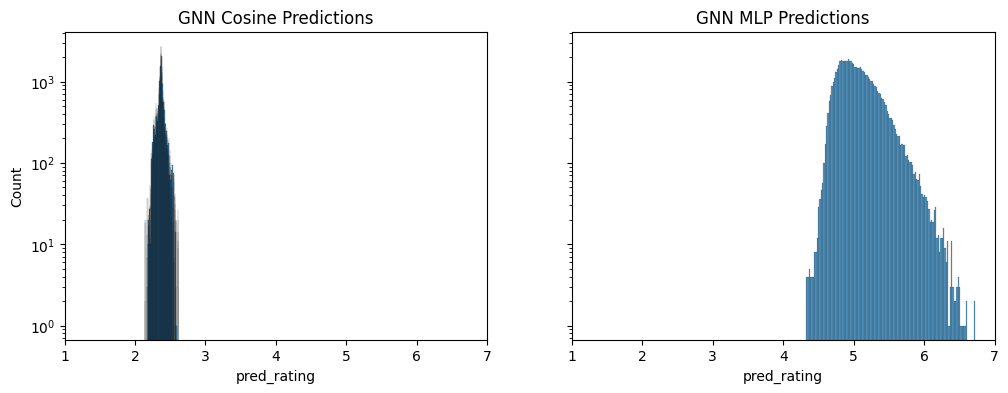

In [196]:
baseline_cos_df = pd.DataFrame(gcn_baseline_cosine)
baseline_mlp_df = pd.DataFrame(gcn_baseline_mlp)

fig, ax = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)

g = sns.histplot(baseline_cos_df, x='pred_rating', ax=ax[0])
g.set_title('GNN Cosine Predictions')
g.set_yscale('log')
g.set_xlim(1, 7)

g = sns.histplot(baseline_mlp_df, x='pred_rating', ax=ax[1])
g.set_title('GNN MLP Predictions')

plt.show()

**Observations:** in neither example, predictions are very varied. We also observe an unfortunate artifact of regression - as the model is not trained for enough epochs, it predicts ratings above 5 (impossible).

#### Evaluate Performance

In [197]:
gcn_cos_performance = {'model': 'gcn_reg_cosine'}
gcn_cos_performance.update(evaluate_recommendations(baseline_cos_df, test, 20))
gcn_cos_performance

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'gcn_reg_cosine',
 'precision@20': 0.11388888888888887,
 'recall@20': 0.10426526756267981,
 'ndcg@20': 0.0022793022441661907,
 'mrr@20': 0.22079765475179564}

In [198]:
gcn_mlp_performance = {'model': 'gcn_reg_mlp'}
gcn_mlp_performance.update(evaluate_recommendations(baseline_mlp_df, test, 20))
gcn_mlp_performance

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'gcn_reg_mlp',
 'precision@20': 0.11197604790419163,
 'recall@20': 0.10394876862867249,
 'ndcg@20': 0.0025940849940200316,
 'mrr@20': 0.21021202008947876}

**Observation:** we observe very similar performance for predictions made with cosine similarity and the mlp-component. However, precision, recall and ndcg is a bit better for mlp-predictions. Other experiments also suggest cosine similarity does not work as well with other architectures than GCN.          

### GCN Baseline (Classification)

In [199]:
# Instantiate the model
config = {
    'train_data': gnn_train_data,
    'test_data': gnn_test_data,
    'gnn_layers': 4,
    'gnn_dropout': 0.0,
    'gnn_hidden_channels':64,
    'mlp_layers': 4,
    'mlp_hidden_channels': 64,
    'mlp_dropout': 0.0,
    'problem_formulation': 'classification',
    'architecture':'GCN',
    'lr': 1e-3,
    'epochs': 100,
    'use_class_weights': False,
    'verbose': False,
}

# Train the model
gcn_clf = train_predictor(config)

Epoch: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


train_loss,██▇▇▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▇▆▅▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,1.26357
val_loss,1.28146


In [200]:
print('Make mlp predictions...')
gcn_baseline_clf = recommend_top_k_books_per_user(gcn_clf, gnn_train_data, k=20, mode='mlp', problem_formulation='classification')

Make mlp predictions...


User: 100%|██████████| 3000/3000 [00:04<00:00, 668.40it/s]


In [201]:
clf_baseline_df = pd.DataFrame(gcn_baseline_clf)

gcn_baseline_clf = {'model': 'gcn_clf'}
gcn_baseline_clf.update(evaluate_recommendations(clf_baseline_df, test, 20))
gcn_baseline_clf

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'gcn_clf',
 'precision@20': 0.11114457831325303,
 'recall@20': 0.10357554519043101,
 'ndcg@20': 0.002585093214685785,
 'mrr@20': 0.21361439087062947}

### GCN Baseline (Classification /w Class Weights)

In [202]:
# Instantiate the model
config = {
    'train_data': gnn_train_data,
    'test_data': gnn_test_data,
    'gnn_layers': 4,
    'gnn_dropout': 0.0,
    'gnn_hidden_channels':64,
    'mlp_layers': 4,
    'mlp_hidden_channels': 64,
    'mlp_dropout': 0.0,
    'problem_formulation': 'classification',
    'architecture':'GCN',
    'lr': 1e-3,
    'epochs': 100,
    'use_class_weights': True,
    'verbose': False,
}

# Train the model
gcn_clf_cw = train_predictor(config)

Epoch: 100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


train_loss,█▆▆▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,██▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▄▄▃▃▃▃▂▃▄▁▄▁▃▂▂▂▂▂▂▂▁▂
train_loss,1.47057
val_loss,1.51281


In [203]:
print('Make mlp predictions...')
gcn_baseline_clf_cw = recommend_top_k_books_per_user(gcn_clf_cw, gnn_train_data, k=20, mode='mlp', problem_formulation='classification')

Make mlp predictions...


User: 100%|██████████| 3000/3000 [00:04<00:00, 666.50it/s]


In [204]:
gcn_clf_df = pd.DataFrame(gcn_baseline_clf_cw)

gcn_clf_cw_performance = {'model': 'gcn_baseline_clf_cw'}
gcn_clf_cw_performance.update(evaluate_recommendations(gcn_clf_df, test, 20))
gcn_clf_cw_performance

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'gcn_baseline_clf_cw',
 'precision@20': 0.10090090090090091,
 'recall@20': 0.09085465190863407,
 'ndcg@20': 0.0015310491608759075,
 'mrr@20': 0.20739227078236364}

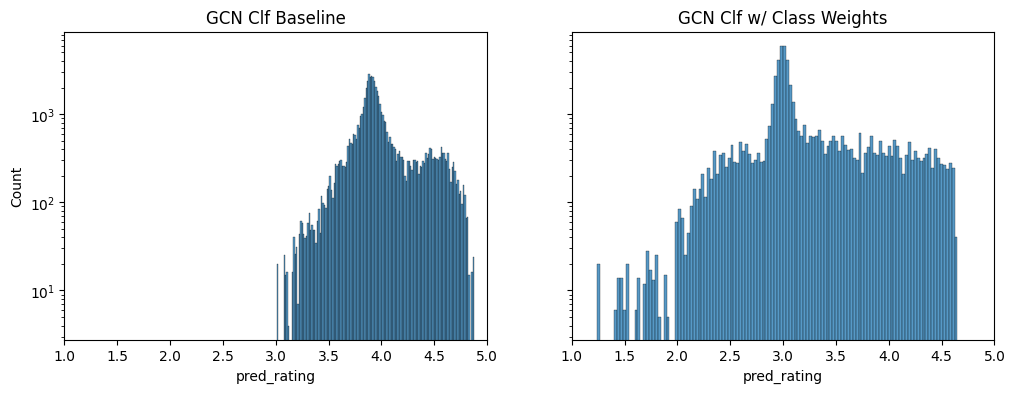

,model,precision@20,recall@20,ndcg@20,mrr@20
0,gcn_reg_mlp,0.111976,0.103949,0.002594,0.210212
1,gcn_clf,0.111145,0.103576,0.002585,0.213614
2,gcn_baseline_clf_cw,0.100901,0.090855,0.001531,0.207392


In [205]:
fig, ax = plt.subplots(1,2, figsize=(12,4), sharex=True, sharey=True)

g = sns.histplot(clf_baseline_df, x='pred_rating', ax=ax[0])
g.set_title('GCN Clf Baseline')
g.set_yscale('log')
g.set_xlim(1, 5)

g = sns.histplot(gcn_clf_df, x='pred_rating', ax=ax[1])
g.set_title('GCN Clf w/ Class Weights')

plt.show()
pd.DataFrame([gcn_mlp_performance, gcn_baseline_clf, gcn_clf_cw_performance])

**Observation:** we observe classification with class weights are producing more varied predictions than our previous models. Despite its slightly worse performance, we hypothesize this architecture to have the highest potential

## GIN

### GIN Baseline (Regression)

In [212]:
# Instantiate the model
config = {
    'train_data': gnn_train_data,
    'test_data': gnn_test_data,
    'gnn_layers': 4,
    'gnn_dropout': 0.0,
    'gnn_hidden_channels':64,
    'mlp_layers': 4,
    'mlp_hidden_channels':64,
    'mlp_dropout': 0.0,
    'problem_formulation': 'regression',
    'architecture':'GIN',
    'lr': 1e-3,
    'epochs': 100,
    'use_class_weights': False,
    'verbose': False,
}

# Train the model
gin_reg = train_predictor(config)

Epoch: 100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


mae,████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁
r2,▁▁▂▂▂▂▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇████
rmse,████▇▇▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▁▁▁
train_loss,█▆▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_loss,██▇▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
mae,1.34777
r2,-1.45095
rmse,1.55377
train_loss,1.19269
val_loss,2.41419


In [213]:
print('Make mlp predictions...')
gin_baseline_reg = recommend_top_k_books_per_user(gin_reg, gnn_train_data, k=20, mode='mlp',problem_formulation='classification')
gin_baseline_df = pd.DataFrame(gin_baseline_reg)
gin_baseline_reg_performance = {'model': 'gin_baseline'}
gin_baseline_reg_performance.update(evaluate_recommendations(gin_baseline_df, test, 20))
gin_baseline_reg_performance

Make mlp predictions...


User: 100%|██████████| 3000/3000 [00:06<00:00, 468.00it/s]
/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'gin_baseline',
 'precision@20': 0.1111111111111111,
 'recall@20': 0.10308779291006528,
 'ndcg@20': 0.0026837442966558384,
 'mrr@20': 0.2237963828779102}

### GIN Baseline (Classification)

In [214]:
# Instantiate the model
config = {
    'train_data': gnn_train_data,
    'test_data': gnn_test_data,
    'gnn_layers': 4,
    'gnn_dropout': 0.0,
    'gnn_hidden_channels':64,
    'mlp_layers': 4,
    'mlp_hidden_channels':64,
    'mlp_dropout': 0.0,
    'problem_formulation': 'classification',
    'architecture':'GIN',
    'lr': 1e-3,
    'epochs': 100,
    'use_class_weights': False,
    'verbose': False,
}

# Train the model
gin_clf = train_predictor(config)

Epoch: 100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


train_loss,█▆▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,██▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_loss,1.31946
val_loss,1.33023


In [216]:
print('Make mlp predictions...')
gin_baseline_clf = recommend_top_k_books_per_user(gin_clf, gnn_train_data, k=20, mode='mlp',problem_formulation='classification')
gin_baseline_clf_df = pd.DataFrame(gin_baseline_reg)
gin_baseline_clf_performance = {'model': 'gin_baseline_clf'}
gin_baseline_clf_performance.update(evaluate_recommendations(gin_baseline_clf_df, test, 20))
gin_baseline_clf_performance

Make mlp predictions...


User: 100%|██████████| 3000/3000 [00:07<00:00, 380.77it/s]
/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'gin_baseline_clf',
 'precision@20': 0.1111111111111111,
 'recall@20': 0.10308779291006528,
 'ndcg@20': 0.0026837442966558384,
 'mrr@20': 0.2237963828779102}

### GIN Baseline (Classification /w Class Weights)

In [206]:
# Instantiate the model
config = {
    'train_data': gnn_train_data,
    'test_data': gnn_test_data,
    'gnn_layers': 4,
    'gnn_dropout': 0.0,
    'gnn_hidden_channels':64,
    'mlp_layers': 4,
    'mlp_hidden_channels':64,
    'mlp_dropout': 0.0,
    'problem_formulation': 'classification',
    'architecture':'GIN',
    'lr': 1e-3,
    'epochs': 100,
    'use_class_weights': True,
    'verbose': False,
}

# Train the model
gin_clf_cw = train_predictor(config)

Epoch: 100%|██████████| 100/100 [00:29<00:00,  3.44it/s]


train_loss,▄█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train_loss,1.60241
val_loss,1.55772


#### Make Recommendations

In [207]:
print('Make mlp predictions...')
gin_baseline = recommend_top_k_books_per_user(gin_clf_cw, gnn_train_data, k=20, mode='mlp',problem_formulation='classification')

Make mlp predictions...


User: 100%|██████████| 3000/3000 [00:04<00:00, 631.28it/s]


#### Evaluate

In [208]:
gin_baseline_df = pd.DataFrame(gin_baseline)
gin_baselin_performance = {'model': 'gin_baseline'}
gin_baselin_performance.update(evaluate_recommendations(gin_baseline_df, test, 20))
gin_baselin_performance

/var/folders/kd/klmddjb57sdc63rvm8msngwh0000gn/T/ipykernel_89009/1958238893.py:45: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  truth_sorted = truth.groupby('user_id').apply(lambda df: df.nlargest(k, 'rating')).reset_index(drop=True)


{'model': 'gin_baseline',
 'precision@20': 0.08692307692307692,
 'recall@20': 0.08034362580007257,
 'ndcg@20': 0.001804283258960285,
 'mrr@20': 0.23861031062954138}